In [1]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.activations import tanh
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [75]:
df = pd.read_csv('london_weather.csv')

In [80]:
df.head()

,mean_temp,max_temp,min_temp,cloud_cover,sunshine,global_radiation,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,-4.1,2.3,-7.5,2.0,7.0,52.0,0.4,101.90,9.0
1979-01-02,-2.6,1.6,-7.5,6.0,1.7,27.0,0.0,102.53,8.0
1979-01-03,-2.8,1.3,-7.2,5.0,0.0,13.0,0.0,102.05,4.0
1979-01-04,-2.6,-0.3,-6.5,8.0,0.0,13.0,0.0,100.84,2.0
1979-01-05,-0.8,5.6,-1.4,6.0,2.0,29.0,0.0,102.25,1.0


In [77]:
df = df.reindex(columns = ['date', 'mean_temp', 'max_temp', 'min_temp', 'cloud_cover', 'sunshine', 
                           'global_radiation', 'precipitation', 'pressure', 'snow_depth'])

In [78]:
# Convert pressure from Pa to KPa
df['pressure'] = df['pressure'] / 1000

In [79]:
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

df = df.set_index('date')

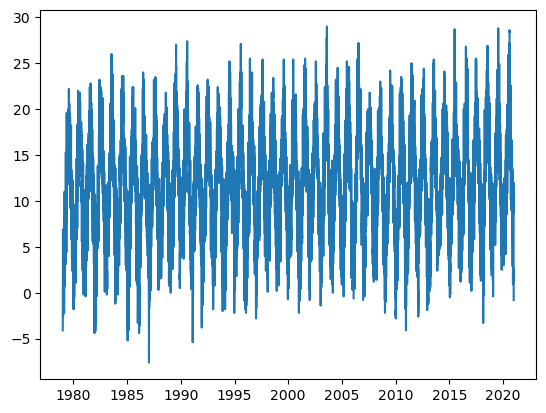

In [41]:
plt.plot(df.index, df['mean_temp'])

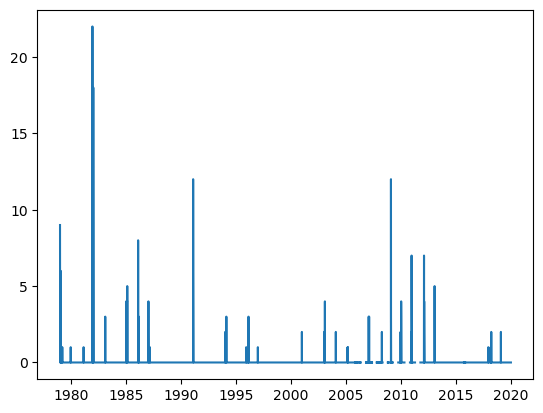

In [55]:
plt.plot(df.index, df['snow_depth'])

In [92]:
# Count NaN values in each column
nan_counts = df.isna().sum()

for col, count in nan_counts.items():
    print(f'{col}: {count}')

mean_temp: 36
max_temp: 6
min_temp: 2
cloud_cover: 19
sunshine: 0
global_radiation: 19
precipitation: 6
pressure: 4
snow_depth: 1441


In [93]:
df = df.dropna()

print(df.shape)

(13843, 9)


# Data preprocessing

In [94]:
# Create a scaling object
scaler = StandardScaler()

# Fit scaler to data
scaler.fit(df)

# Scale everything
scaled_data = scaler.fit_transform(df)

In [95]:
scaled_data.shape

(13843, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


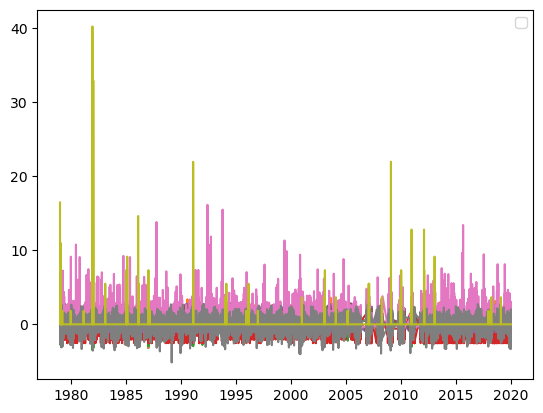

In [96]:
plt.plot(df.index, scaled_data)
plt.legend()

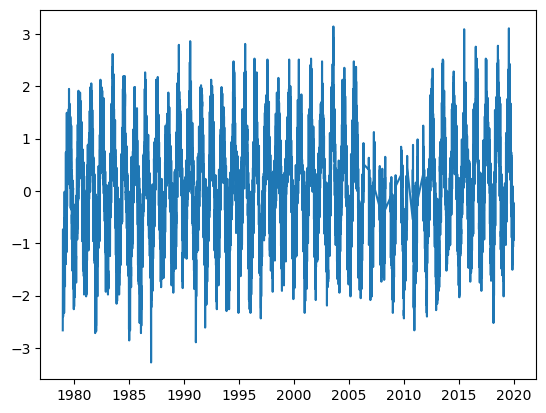

In [98]:
plt.plot(df.index, scaled_data[:,0])

Note that the errant 35+ data comes from the snowfall, which we will keep in our data for now and see if that impacts the training of our model

In [110]:
# Create the training and testing data using an 80-20 split
X_train = scaled_data[:12272, 1:]
y_train = scaled_data[:12272, 0]

X_test = scaled_data[12273:, 1:]
y_test = scaled_data[12273:, 0]

In [100]:
model = Sequential([
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1)
])

In [101]:
optimizer = optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [102]:
history = model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0628 - mean_absolute_error: 0.1625
Epoch 2/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0246 - mean_absolute_error: 0.1222
Epoch 3/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0242 - mean_absolute_error: 0.1204
Epoch 4/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0248 - mean_absolute_error: 0.1206
Epoch 5/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0235 - mean_absolute_error: 0.1185
Epoch 6/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0231 - mean_absolute_error: 0.1182
Epoch 7/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0239 - mean_absolute_error: 0.1182
Epoch 8/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0231 - mean_absolute_error: 0.1178
Epoch 9/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0222 - mean_absolute_error: 0.1159
E

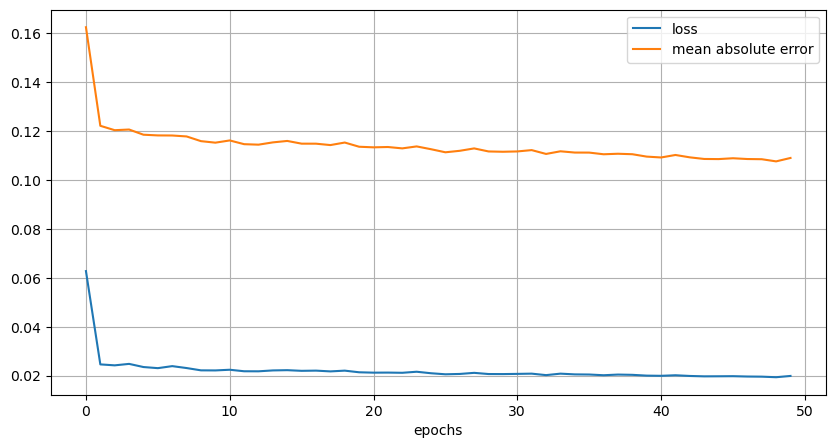

In [108]:
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['mean_absolute_error'], label = 'mean absolute error')
plt.xlabel('epochs')
plt.grid(True)
plt.legend()

In [111]:
model.evaluate(X_test, y_test)

50/50 [==============================] - 0s 1ms/step - loss: 0.0276 - mean_absolute_error: 0.1260


[0.02761831507086754, 0.12597259879112244]